In [1]:
import numpy as np
from multiprocessing import Pool
from numba import njit
import math
import matplotlib.pyplot as plt

In [2]:
@njit
def eggbox(x1, x2):
    """
    Calculate the potential O1(x1, x2) = (2 + cos(x1/2) * cos(x2/2))^5.

    Parameters:
    x1 (float): The first input variable.
    x2 (float): The second input variable.

    Returns:
    float: The value of the potential O1(x1, x2).
    """
    obs = (2.0 + math.cos(x1 / 2.0) * math.cos(x2 / 2.0)) ** 5
    return obs

In [3]:
@njit
def likelihood(state, O_star=100, sigma_star=10):
    """
    Compute the Gaussian-like function L(x1, x2) = exp(-(O(x1, x2) - O_star)^2 / (2 * sigma_star^2)).

    Parameters:
    x1 (float): The first input variable.
    x2 (float): The second input variable.
    O_star (float): The target value for the potential.
    sigma_star (float): The width parameter of the Gaussian.
    O (function): The potential function O(x1, x2).

    Returns:
    float: The value of L(x1, x2).
    """
    # Compute the potential O(x1, x2)
    x1, x2 = state[0], state[1]
    potential = eggbox(x1, x2)
    
    # Compute the Gaussian-like function
    exponent = -((potential - O_star) ** 2) / (2 * sigma_star ** 2)
    return math.exp(exponent)

In [4]:
def prior(params):
    # Placeholder for the prior distribution
    # Replace this with your actual prior function
    return 1.0  # Uniform prior for simplicity

In [5]:
def propose(params, proposal_scale=1.0):
    # Proposal distribution: Gaussian centered at current parameters
    return params + np.random.normal(0, proposal_scale, size=params.shape)

In [6]:
def mcmc_chain(initial_params, n_iterations, proposal_scale):
    # Run a single MCMC chain
    chain = np.zeros((n_iterations, len(initial_params)))
    likelihood_chain = np.zeros(n_iterations)
    current_params = initial_params
    current_likelihood = likelihood(current_params) * prior(current_params)
    
    for i in range(n_iterations):
        proposed_params = propose(current_params, proposal_scale)
        proposed_likelihood = likelihood(proposed_params) * prior(proposed_params)
        
        # Metropolis-Hastings acceptance criterion
        acceptance_ratio = proposed_likelihood / current_likelihood
        if np.random.rand() < acceptance_ratio:
            current_params = proposed_params
            current_likelihood = proposed_likelihood
    
        chain[i] = current_params
        likelihood_chain[i] = current_likelihood
    return chain, likelihood_chain

In [7]:
def exchange_chains(chain1, chain2, likelihood1, likelihood2):
    # Exchange states between two chains with probability satisfying detailed balance
    acceptance_prob = min(1, likelihood2 / likelihood1)
    
    if np.random.rand() < acceptance_prob:
        # Swap the last states and their likelihoods
        chain1[-1], chain2[-1] = chain2[-1], chain1[-1]
        likelihood1, likelihood2 = likelihood2, likelihood1
    
    return chain1, chain2, likelihood1, likelihood2

In [9]:
def temporal_parallel_mcmc(initial_params, n_chains, n_iterations, proposal_scales, exchange_interval=100):
    # Run multiple MCMC chains in parallel with periodic probabilistic exchange
    pool = Pool(processes=n_chains)
    chains = [initial_params[i] + np.random.normal(0, proposal_scales[i], size=initial_params[i].shape) for i in range(n_chains)]
    all_chains = []
    all_likelihoods = []
    
    for iteration in range(0, n_iterations, exchange_interval):
        # Run each chain for `exchange_interval` iterations
        results = pool.starmap(mcmc_chain, [(chain, exchange_interval, proposal_scales[i]) for i, chain in enumerate(chains)])
        
        # Update chains with the last state of each chain
        chains = [result[0][-1] for result in results] # Update chains with the last state
        likelihoods = [result[1][-1] for result in results] # Update likelihoods with the last value

        # Store the results from this batch of iterations
        all_chains.extend([result[0] for result in results])
        all_likelihoods.extend([result[1] for result in results])
        
        # Probabilistically exchange information between chains
        if n_chains > 1:
            for i in range(0, n_chains - 1, 2):
                chains[i], chains[i+1], likelihoods[i], likelihoods[i+1] = exchange_chains(
                    chains[i], chains[i+1], likelihoods[i], likelihoods[i+1]
                )
    pool.close()
    pool.join()
    
    # Combine results from all chains
    final_chain = np.concatenate(all_chains)
    final_likelihoods = np.concatenate(all_likelihoods)
    return final_chain, final_likelihoods

Final chain shape: (5500000, 2)
Final likelihood shape: (5500000,)


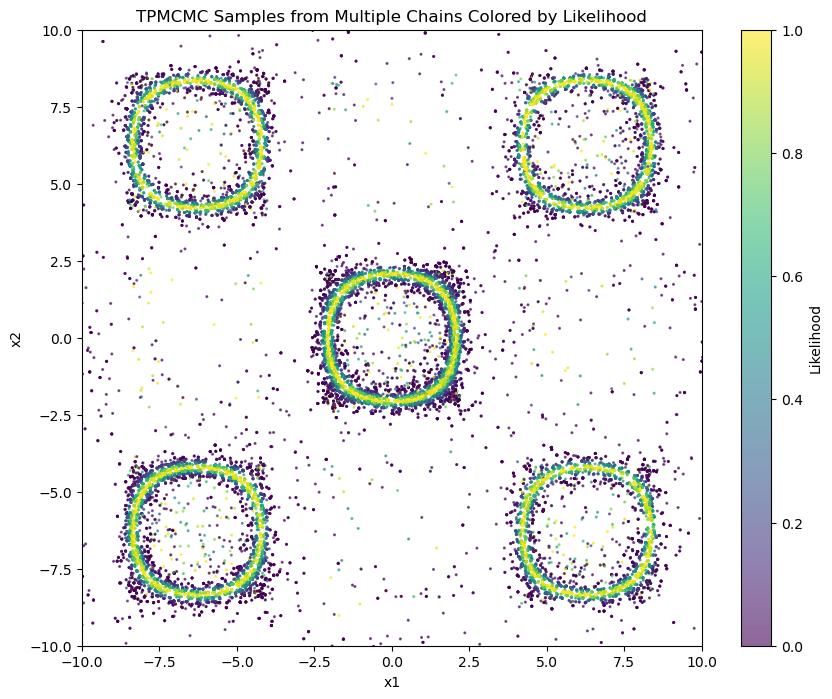

In [21]:
# Example usage
if __name__ == "__main__":
    seed = 0
    np.random.seed(seed)
    # Heatmap range parameters
    x1_range = (-10, 10)  # Range for x1 axis
    x2_range = (-10, 10)  # Range for x2 axis
    proposal_stds = [
        np.array([1.0, 1.0]),
        np.array([1.5, 1.5]),
        np.array([2.0, 2.0]),
        np.array([2.5, 2.5]),
        np.array([3.0, 3.0]),
        np.array([3.5, 3.5]),
        np.array([4.0, 4.0]),
        np.array([4.5, 4.5]),
        np.array([5.0, 5.0]),
        np.array([5.5, 5.5]),
        np.array([6.0, 6.0]),
    ]  # Std for each chain
    # Initialize chains with random starting points
    num_chains = len(proposal_stds)  # Number of parallel chains
    #proposal_stds = np.random.uniform(low=[0.5, 0.5], high=[5.0, 5.0], size=(num_chains, 2))
    initial_params = np.random.uniform(low=[x1_range[0], x2_range[0]], high=[x1_range[1], x2_range[1]], size=(num_chains, 2)) # Initial parameters
    num_iterations = 500000  # Total number of iterations
    exchange_interval = 10  # Interval for exchanging information between chains
    
    final_chain, final_likelihoods = temporal_parallel_mcmc(initial_params, num_chains, num_iterations, proposal_stds, exchange_interval)
    #final_chain, final_likelihoods = temporal_parallel_mcmc(initial_params, num_chains, num_iterations)
    #print("Final chain shape:", final_chain.shape)
    #print("Final likelihood shape:", final_likelihoods.shape)
    # Create a heatmap of the samples, colored by their likelihood
    plt.figure(figsize=(10, 8))
    plt.scatter(final_chain[:, 0], final_chain[:, 1], c=final_likelihoods, cmap='viridis', alpha=0.6, s=1.5)
    plt.colorbar(label='Likelihood')

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('TPMCMC Samples from Multiple Chains Colored by Likelihood')

    # Set the range of the heatmap
    plt.xlim(x1_range)
    plt.ylim(x2_range)

    plt.show()